## HBase 

In [5]:
import pandas as pd
import numpy as np
import os
from os.path import join, pardir
import sys

SCRIPT_DIR = os.path.dirname(os.path.realpath(sys.path[0]))
DATA_DIR = join(SCRIPT_DIR, pardir, 'data', 'zookeeper_utilization')

dfs = []
for idx in range(1,4):
    df = pd.read_csv(join(DATA_DIR, 'hbase', f'zoo_{idx}.csv'), header=0)
    df['server'] = idx
    dfs.append(df)
df = pd.concat(dfs)


df['mem_usage'] = (1 - df['mem_avail']/df['mem_total'])*100

start_timestamp = df.loc[df['server'] == 1]['timestamp'].iloc[0]

df['timestamp_relative'] = df['timestamp'] - start_timestamp
df['timestamp_relative'] /= 1000.0 * 1000.0 * 1000.0

for server in [1,2,3]:
    df.loc[df['server'] == server, 'zk_reads_relative'] = df.loc[df['server'] == server]['zk_reads'] - df.loc[df['server'] == server]['zk_reads'].iloc[0]
    df.loc[df['server'] == server, 'zk_writes_relative'] = df.loc[df['server'] == server]['zk_writes'] - df.loc[df['server'] == server]['zk_writes'].iloc[0]

# too slow to plot
df['date'] = pd.to_datetime(df['timestamp_relative'], unit='ms')
#df['date'] = pd.to_datetime(df['timestamp_relative'], unit='ms').dt.strftime('%H:%M:%S.%f')

print(df)


                 timestamp  cpu_user  cpu_nice  cpu_system  cpu_idle  \
0      1698782289736850220     14960       637        6022   6321181   
1      1698782289786893213     14960       637        6022   6321191   
2      1698782289836935069     14960       637        6022   6321201   
3      1698782289886948098     14961       637        6022   6321209   
4      1698782289936992367     14961       637        6022   6321219   
...                    ...       ...       ...         ...       ...   
38046  1698784200673736688     15087       441        6212   6708168   
38047  1698784200723773843     15088       441        6212   6708178   
38048  1698784200773818262     15088       441        6212   6708188   
38049  1698784200823866016     15088       441        6212   6708197   
38050  1698784200873896619     15088       441        6212   6708207   

       mem_total  mem_free  mem_avail  ens5_rx_bytes  ens5_tx_bytes  zk_reads  \
0        3940012   1976476    3328632      217085747  

In [6]:
import datetime

times = ['Tue Oct 31 19:58:23 UTC 2023', 'Tue Oct 31 20:03:29 UTC 2023', 'Tue Oct 31 20:08:34 UTC 2023', 'Tue Oct 31 20:13:40 UTC 2023', 'Tue Oct 31 20:18:46 UTC 2023', 'Tue Oct 31 20:24:19 UTC 2023', 'Tue Oct 31 20:29:24 UTC 2023']
dates = []

ts = start_timestamp / 1000 / 1000 /1000
#ts = datetime.datetime.fromtimestamp(start_timestamp / 1000 / 1000 /1000)
for time in times:
    t = datetime.datetime.strptime(time, "%a %b %d %H:%M:%S %Z %Y").timestamp()
    # accommodate for the one hour shift between VMs and timestamps
    dates.append(t + 3600 - ts)
    
print(dates)

[13.263149738311768, 319.26314973831177, 624.2631497383118, 930.2631497383118, 1236.2631497383118, 1569.2631497383118, 1874.2631497383118]


In [7]:


new_df = []

cur_time = -1
next_time = 0

zk_summary = []

for index, row in df.loc[df['server'] == 1].iterrows():
    #print(index, row)
    
    if row['timestamp_relative'] >= next_time:
        next_time += 1
        
        # compute CPU utilization
        if len(new_df) == 0:
            row['cpu_usage'] = 0
            new_df.append(row)
        else:

            prev_idle = new_df[-1]['cpu_idle']
            prev_nonidle = new_df[-1]['cpu_user'] + new_df[-1]['cpu_nice'] + new_df[-1]['cpu_system']
            prev_total = prev_idle + prev_nonidle

            idle = row['cpu_idle']
            nonidle = row['cpu_user'] + row['cpu_nice'] + row['cpu_system']
            total = idle + nonidle


            nonidle_df = nonidle - prev_nonidle
            total_df = total - prev_total

            row['cpu_usage'] = nonidle_df / total_df

        if len(zk_summary) == 0:
            zk_summary.append([row['timestamp_relative'], row['zk_reads_relative'], row['zk_writes_relative'], 0, 0])
        else:
            #print(zk_summary[-1])
            #print(row['zk_reads_relative'])
            #print(row['zk_writes_relative'])
            prev_r = zk_summary[-1][1]
            prev_w = zk_summary[-1][2]
            zk_summary.append([row['timestamp_relative'], row['zk_reads_relative'], row['zk_writes_relative'], row['zk_reads_relative']-prev_r, row['zk_writes_relative']-prev_w])
            
        new_df.append(row)
    
        cur_time = -1
next_time = 0
cnt = 0

for index, row in df.loc[df['server'] == 2].iterrows():
    #print(index, row)
    
    if row['timestamp_relative'] >= next_time:
        next_time += 1
        
        # compute CPU utilization
        if len(new_df) == 0:
            row['cpu_usage'] = 0
            new_df.append(row)
            continue

        prev_idle = new_df[-1]['cpu_idle']
        prev_nonidle = new_df[-1]['cpu_user'] + new_df[-1]['cpu_nice'] + new_df[-1]['cpu_system']
        prev_total = prev_idle + prev_nonidle
        
        idle = row['cpu_idle']
        nonidle = row['cpu_user'] + row['cpu_nice'] + row['cpu_system']
        total = idle + nonidle
            
            
        nonidle_df = nonidle - prev_nonidle
        total_df = total - prev_total
        
        row['cpu_usage'] = nonidle_df / total_df
        
        if cnt != 0:
            
            prev_r = df.loc[df['server'] == 2].iloc[index-1]['zk_reads_relative']
            prev_w = df.loc[df['server'] == 2].iloc[index-1]['zk_writes_relative']
            #print(prev_r, prev_w, )
            #print(row)
            if cnt >= len(zk_summary):
                #zk_summary.append(zk_summary[-1])
                
                total_r = row['zk_reads_relative'] + zk_summary[-1][1] - prev_r
                total_w = row['zk_writes_relative'] + zk_summary[-1][2] - prev_w
                zk_summary.append([row['timestamp_relative'], total_r, total_w, row['zk_reads_relative'] - prev_r, row['zk_writes_relative'] - prev_w])
            else:
                
                zk_summary[cnt][1] += row['zk_reads_relative'] 
                zk_summary[cnt][2] += row['zk_writes_relative']
                zk_summary[cnt][3] += row['zk_reads_relative'] - prev_r
                zk_summary[cnt][4] += row['zk_writes_relative'] - prev_w
        cnt += 1
    
        new_df.append(row)
        
cur_time = -1
next_time = 0
cnt = 0

for index, row in df.loc[df['server'] == 3].iterrows():
    #print(index, row)
    
    if row['timestamp_relative'] >= next_time:
        next_time += 1
        
        # compute CPU utilization
        if len(new_df) == 0:
            row['cpu_usage'] = 0
            new_df.append(row)
            continue

        prev_idle = new_df[-1]['cpu_idle']
        prev_nonidle = new_df[-1]['cpu_user'] + new_df[-1]['cpu_nice'] + new_df[-1]['cpu_system']
        prev_total = prev_idle + prev_nonidle
        
        idle = row['cpu_idle']
        nonidle = row['cpu_user'] + row['cpu_nice'] + row['cpu_system']
        total = idle + nonidle
            
            
        nonidle_df = nonidle - prev_nonidle
        total_df = total - prev_total
        
        row['cpu_usage'] = nonidle_df / total_df
        
        if cnt != 0:
            
            prev_r = df.loc[df['server'] == 3].iloc[index-1]['zk_reads_relative']
            prev_w = df.loc[df['server'] == 3].iloc[index-1]['zk_writes_relative']
            #print(prev_r, prev_w, )
            #print(row)
            if cnt >= len(zk_summary):
                #zk_summary.append(zk_summary[-1])
                
                total_r = row['zk_reads_relative'] + zk_summary[-1][1] - prev_r
                total_w = row['zk_writes_relative'] + zk_summary[-1][2] - prev_w
                zk_summary.append([row['timestamp_relative'], total_r, total_w, row['zk_reads_relative'] - prev_r, row['zk_writes_relative'] - prev_w])
            else:
                
                zk_summary[cnt][1] += row['zk_reads_relative'] 
                zk_summary[cnt][2] += row['zk_writes_relative']
                zk_summary[cnt][3] += row['zk_reads_relative'] - prev_r
                zk_summary[cnt][4] += row['zk_writes_relative'] - prev_w
        cnt += 1
    
        new_df.append(row)
        

#print(new_df)
new_df = pd.DataFrame(new_df)
zk_summaries = pd.DataFrame(data=zk_summary, columns=['relative_timestamp', 'zk_reads_total', 'zk_writes_total', 'zk_reads', 'zk_writes'])
#print(new_df)
print(zk_summaries)

      relative_timestamp  zk_reads_total  zk_writes_total  zk_reads  zk_writes
0               0.000000             0.0              0.0       0.0        0.0
1               1.001200             0.0              0.0       0.0        0.0
2               2.002273             0.0              0.0       0.0        0.0
3               3.003399             0.0              0.0       0.0        0.0
4               4.004442             0.0              0.0       0.0        0.0
...                  ...             ...              ...       ...        ...
1907         1907.030101           609.0             12.0       0.0        0.0
1908         1908.031054           609.0             12.0       0.0        0.0
1909         1909.032202           609.0             12.0       0.0        0.0
1910         1910.034328           609.0             12.0       0.0        0.0
1911         1911.036968           609.0             12.0       0.0        0.0

[1912 rows x 5 columns]


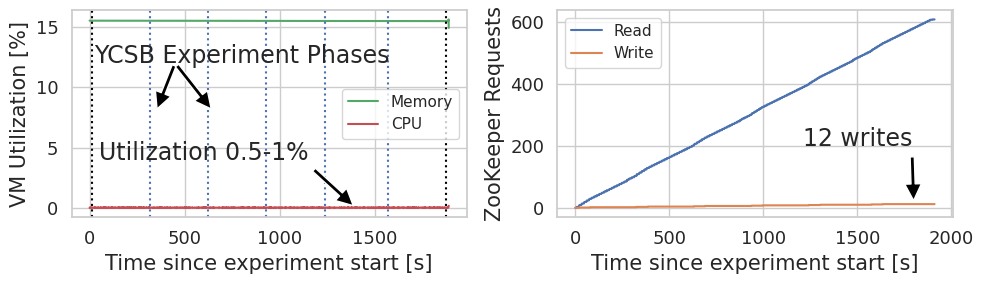

In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

DATA_DIR = join(pardir, pardir, 'data', 'read')

#sns.set(rc={'figure.figsize':(16,8)})
sns.set(rc={'figure.figsize':(10,3)})
sns.set_style("whitegrid")

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(1,4)
os = fig3.add_subplot(gs[0, 0:2])
zk = fig3.add_subplot(gs[0, 2:4])


sns.lineplot(new_df.loc[new_df['server'] ==1], x='timestamp_relative', y='mem_usage',ax=os, color='g', label="Memory")
sns.lineplot(new_df.loc[new_df['server'] ==1], x='timestamp_relative', y='cpu_usage',ax=os, color='r', label="CPU")
os.set_ylabel('VM Utilization [%]',  fontsize=15)
os.set_xlabel("Time since experiment start [s]",  fontsize=15)

for t in dates[1:-1]:
    os.axvline(x = t, color = 'b', linestyle='dotted')
    
for t in [dates[0], dates[-1]]:
    os.axvline(x = t, color = 'black', linestyle='dotted')

#sns.lineplot(new_df, x='timestamp_relative', y='zk_reads_relative', hue='server', ax=zk, palette=['r', 'g', 'b'])
#sns.lineplot(new_df, x='timestamp_relative', y='zk_writes_relative', hue='server', ax=zk, palette=['r', 'g', 'b'],linestyle='dashed')

#zk_second = zk.twinx()
#sns.lineplot(zk_summaries, x='relative_timestamp', y='zk_reads', ax=zk)
sns.lineplot(zk_summaries, x='relative_timestamp', y='zk_reads_total', ax=zk, label='Read')
sns.lineplot(zk_summaries, x='relative_timestamp', y='zk_writes_total', ax=zk, label='Write')
#sns.lineplot(zk_summaries, x='relative_timestamp', y='zk_writes', ax=zk, label='Write')

zk.set_ylabel('ZooKeeper Requests',  fontsize=15)
zk.set_xlabel("Time since experiment start [s]",  fontsize=15)
#zk.set_xticks(fontsize=13)
#zk.set_yticks(fontsize=13)

os.tick_params(axis='both', which='major', labelsize=13)
zk.tick_params(axis='both', which='major', labelsize=13)

handles, labels = zk.get_legend_handles_labels()
#os.set_ylim([0,20])


zk.annotate('12 writes', 
            xy=(1800, 15), xytext=(1500, 200), fontsize=17, ha='center', arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1))


os.annotate('Utilization 0.5-1%', 
            xy=(1400, 0), xytext=(600, 4), fontsize=17, ha='center', arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1))

os.annotate('YCSB Experiment Phases', 
            xy=(250, 5), xytext=(800, 12), fontsize=17, ha='center')
os.annotate('',
            xy=(350, 8), xytext=(450, 12), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
os.annotate('',
            xy=(650, 8), xytext=(450, 12), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

plt.tight_layout()
plt.savefig("hbase_utilization.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

In [9]:
import os
SCRIPT_DIR = os.path.dirname(os.path.realpath(sys.path[0]))
DATA_DIR = join(SCRIPT_DIR, pardir, 'data', 'zookeeper_utilization')

df = pd.read_csv(join(DATA_DIR, 'hbase', f'node_stats.csv'), header=0)
print(df)
print(df['length'].min())
print(df['length'].median())
print(df['length'].mean())
print(df['length'].quantile(.90))
print(df['length'].quantile(.95))
print(df['length'].max())

    Unnamed: 0                                  path  length
0            0                                /hbase       0
1            1             /hbase/meta-region-server      53
2            2                             /hbase/rs       0
3            3  /hbase/rs/slave1,16020,1698778362441     320
4            4  /hbase/rs/slave3,16020,1698778362843     320
5            5  /hbase/rs/slave2,16020,1698778363089     320
6            6                       /hbase/splitWAL       0
7            7                 /hbase/backup-masters       0
8            8               /hbase/flush-table-proc       0
9            9         /hbase/flush-table-proc/abort       0
10          10      /hbase/flush-table-proc/acquired       0
11          11       /hbase/flush-table-proc/reached       0
12          12             /hbase/master-maintenance       0
13          13                /hbase/online-snapshot       0
14          14          /hbase/online-snapshot/abort       0
15          15       /hb